# Analysis

After running `compare.py` on various sources (chng, nchs, dsew, hhs, quidel), this analysis notebook pinpoints where/when the difference between api and S3 happened.

Read all json files in current dir to a df.

In [184]:
import glob
import pandas as pd
# Create a histogram of the 'signal' column
import matplotlib.pyplot as plt

json_files = glob.glob('./json_files/*.json')

# Read all the JSON files into a list of DataFrames
dfs = [pd.read_json(file) for file in json_files]

# Concatenate all the DataFrames into one
df = pd.concat(dfs, ignore_index=True)
print(df.columns)
df['time_value'] = df['time_value'].fillna(0).astype(int)


Index(['file_name', 'source', 'signal', 'time_value', 'geo_type',
       'dif_row_count', 's3_row_count', 'api_row_count', 'full_dif', 'skip',
       'reason'],
      dtype='object')


In [185]:
def generate_diff_plot(source, df_match, df_diff):
    plt.figure(figsize=(25, 10))
    plt.hist(df_match['signal'], bins=40, linestyle=':', label='no difference')
    plt.hist(df_diff['signal'], bins=40, label='difference')
    plt.legend(loc='upper right')
    
    # Set the labels and title
    plt.xlabel('Signals')
    plt.ylabel('Number of csv files on S3 (log scale)')
    plt.title(f'S3 files with difference from API vs no diff by {source} signals')
    plt.xticks(rotation=45, ha='right')
    plt.yscale("log")
    # Display the plot
    plt.show()
    

In [186]:
def generate_diff_over_time_plot(source, df_diff):
    # Create a plot
    plt.figure(figsize=(20, 5))
    plt.bar(df_diff['time_value'], df_diff['dif_row_count'], alpha=0.5)
    
    # Set the labels and title
    plt.xlabel('Time Value')
    plt.ylabel('Number of Row differences in each S3 csv file')
    plt.title(f'Number of Row differences over Time ({source})')
    plt.yscale("log")
    # Display the plot
    plt.show()
    

## General Analysis
After missingness is taken into account, less than 10% of the files have differences.

In [187]:
print('number of s3 csv files processed by compare.py',len(df))
print('number of s3 csv files with differences found',len(df[df['dif_row_count']!=0]))

number of s3 csv files processed by compare.py 438164
number of s3 csv files with differences found 40440


## Specific Indicators
#### 1. Quidel
Vast majority of quidel s3 files have all rows matching api equivalent.
Smoothed signals have more differences than non-smoothed signals.
2 big spikes in 2022 and throughout mid 2023. 

In [188]:
quidel = df[df["source"]=="quidel"]

In [189]:
print(f"Files with mismatched rows: {len(quidel[quidel['dif_row_count']!=0])}")
print(f"Files processed: {len(quidel)}")
print(f"Rate of problematic files: {len(quidel[quidel['dif_row_count']!=0])/len(quidel)}")

Files with mismatched rows: 4796
Files processed: 124647
Rate of problematic files: 0.038476658082424765


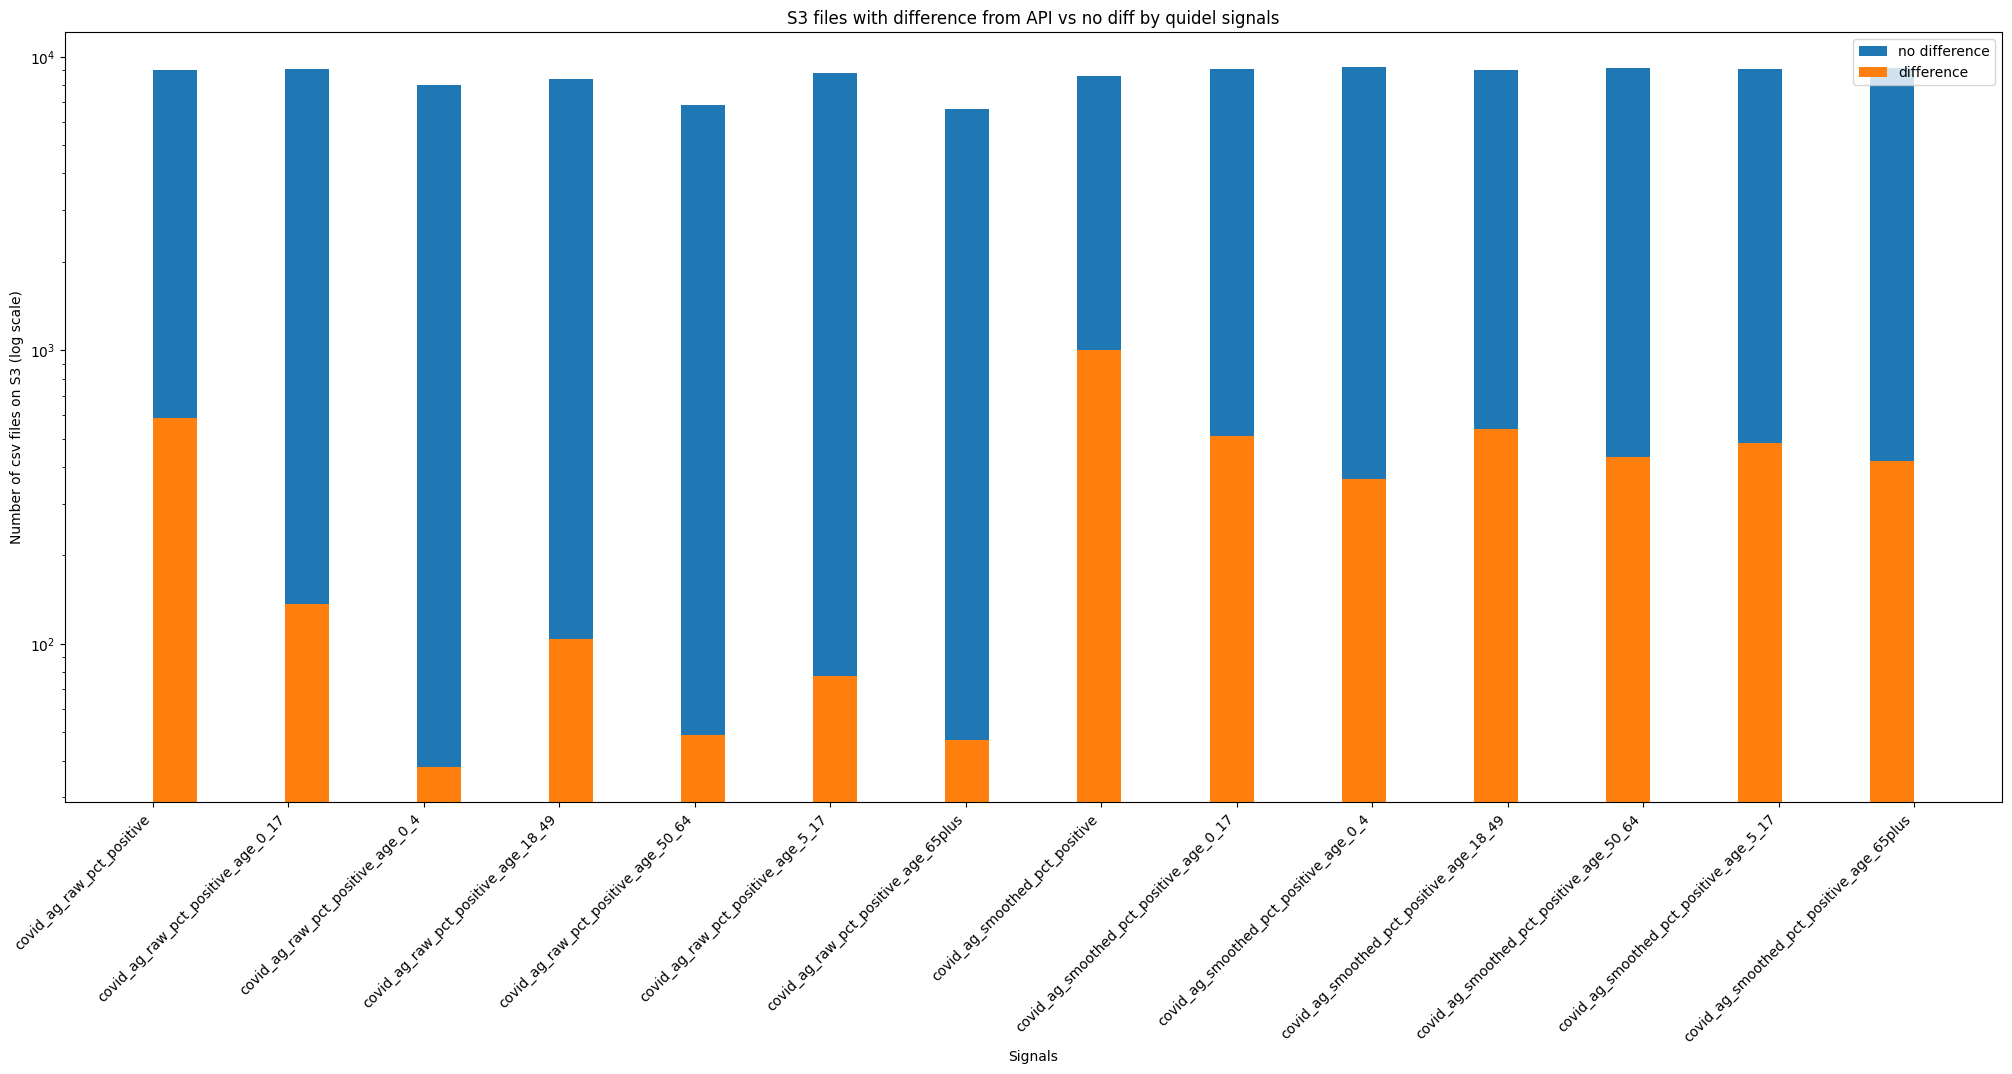

In [190]:
quidel_match = quidel[quidel['dif_row_count']==0]
quidel_diff = quidel[quidel['dif_row_count']!=0]
generate_diff_plot("quidel", quidel_match, quidel_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/1511837741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')


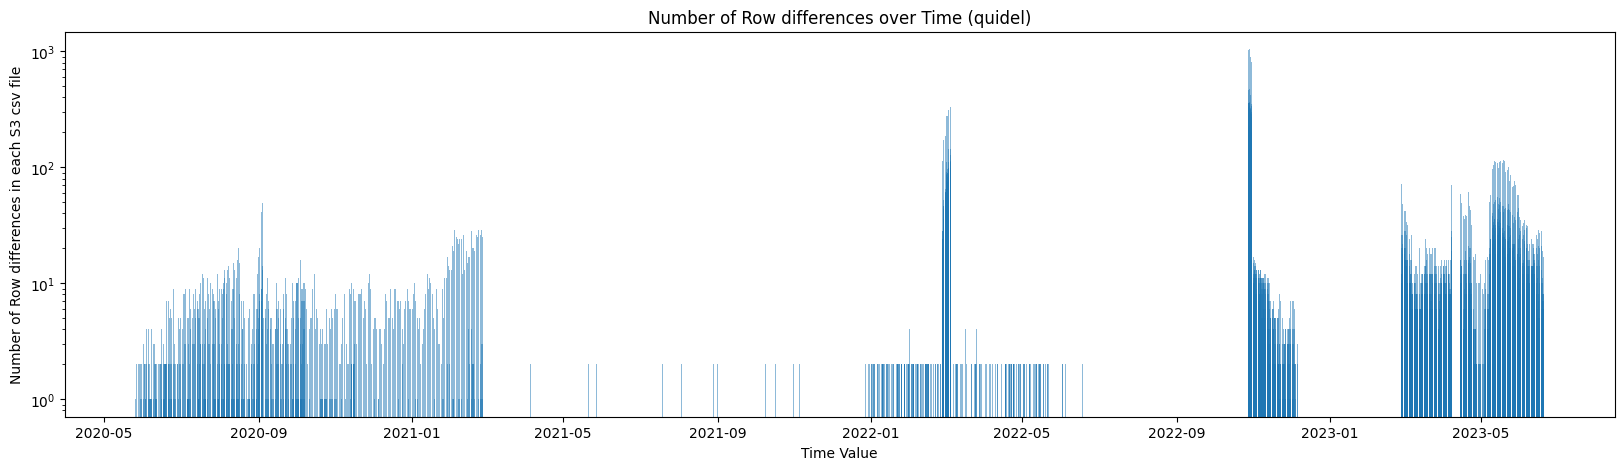

In [191]:
quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("quidel", quidel_diff)

#### 2. nchs

Note: This indicator uses its own version of the archive differ, which outputs a different csv structure, causing wrong result in previous analysis.

With that and missingness taken into account, this time we see the indicator has 13% of files being different from its equivalent api result, with the biggest spike in mid 2023.

In [192]:
nchs = df[df["source"]=="nchs-mortality"]

In [193]:
print(f"Files with mismatched rows: {len(nchs[nchs['dif_row_count']!=0])}")
print(f"Files processed: {len(nchs)}")
print(f"Rate of problematic files: {len(nchs[nchs['dif_row_count']!=0])/len(nchs)}")

Files with mismatched rows: 953
Files processed: 7046
Rate of problematic files: 0.1352540448481408


In [194]:
nchs_diff = nchs[(nchs['dif_row_count']!=0) & (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0]

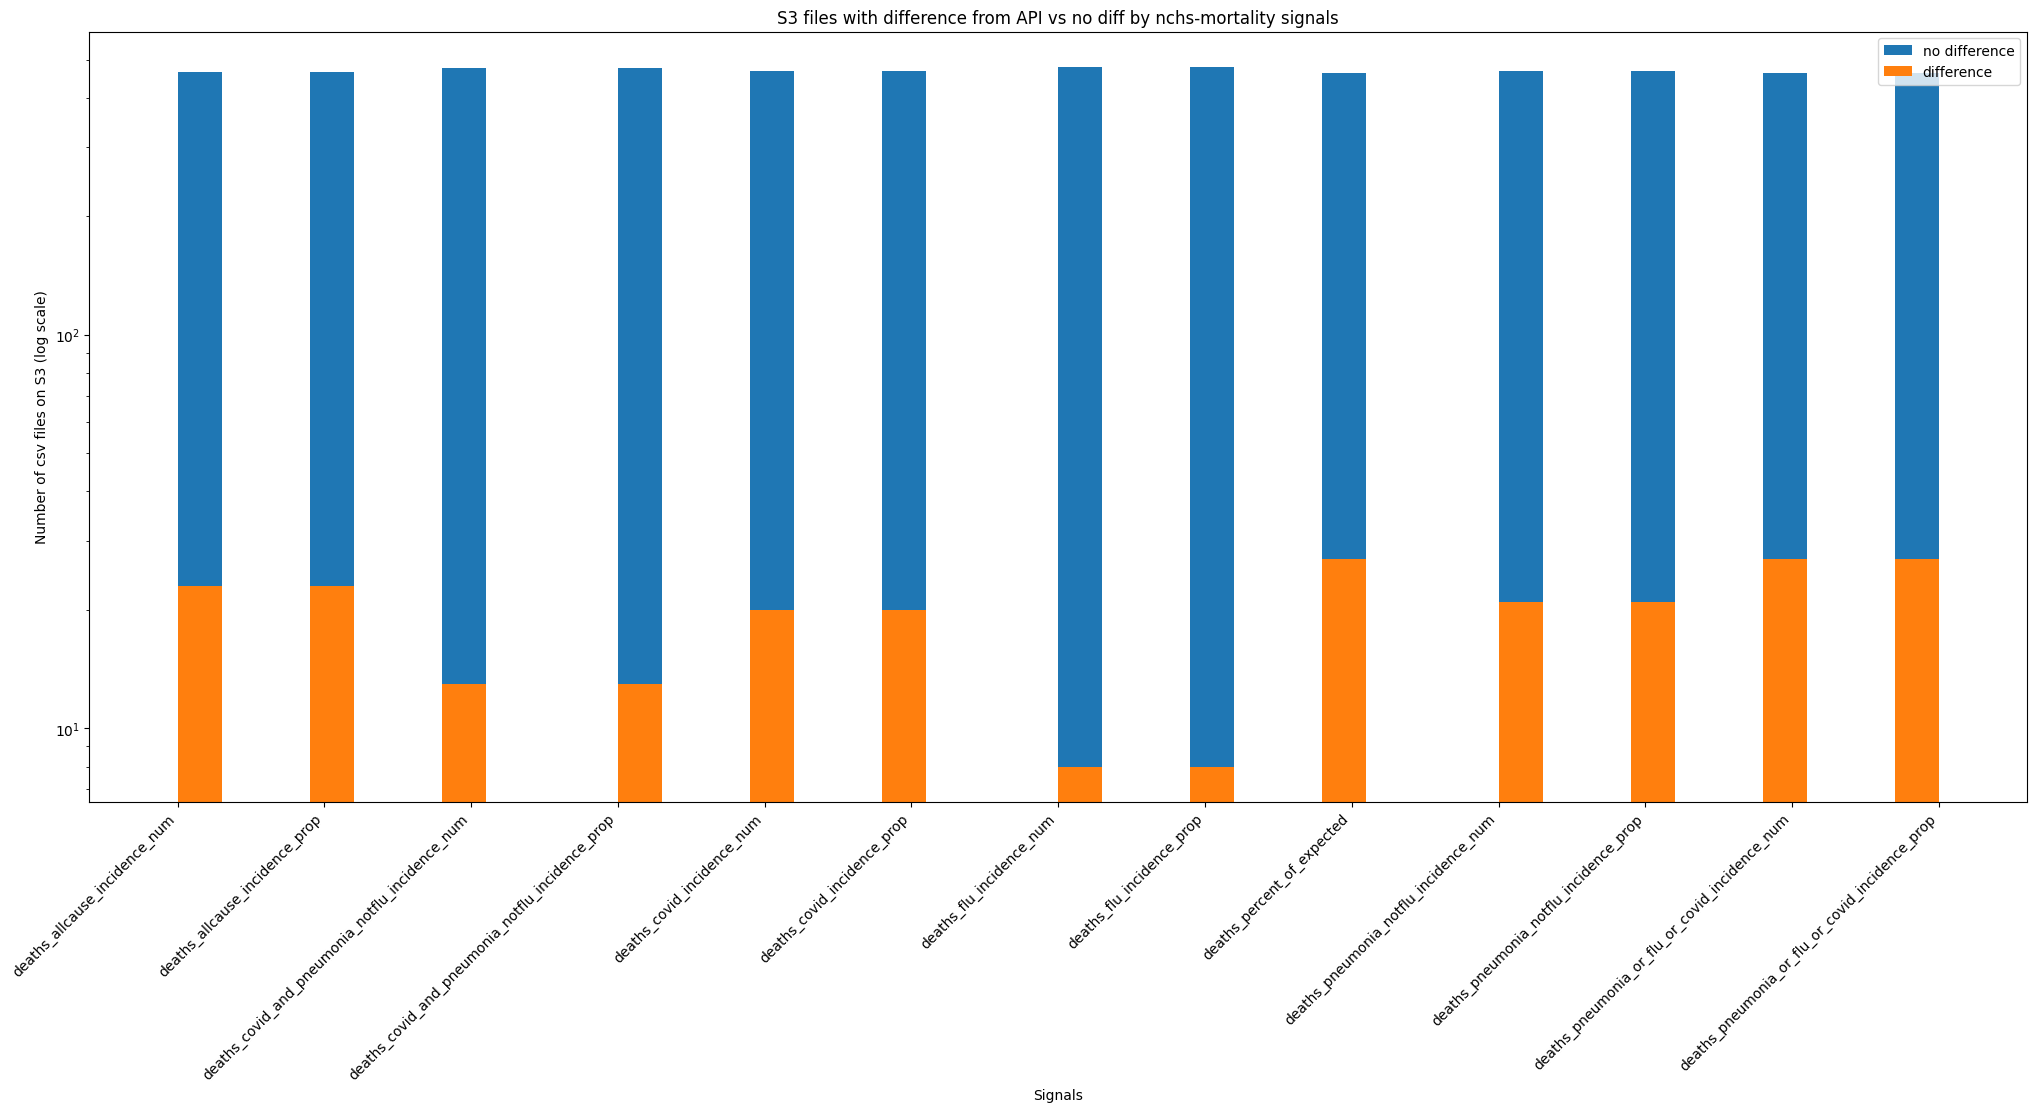

In [195]:
generate_diff_plot("nchs-mortality", nchs_match, nchs_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/3038757178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/3038757178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')


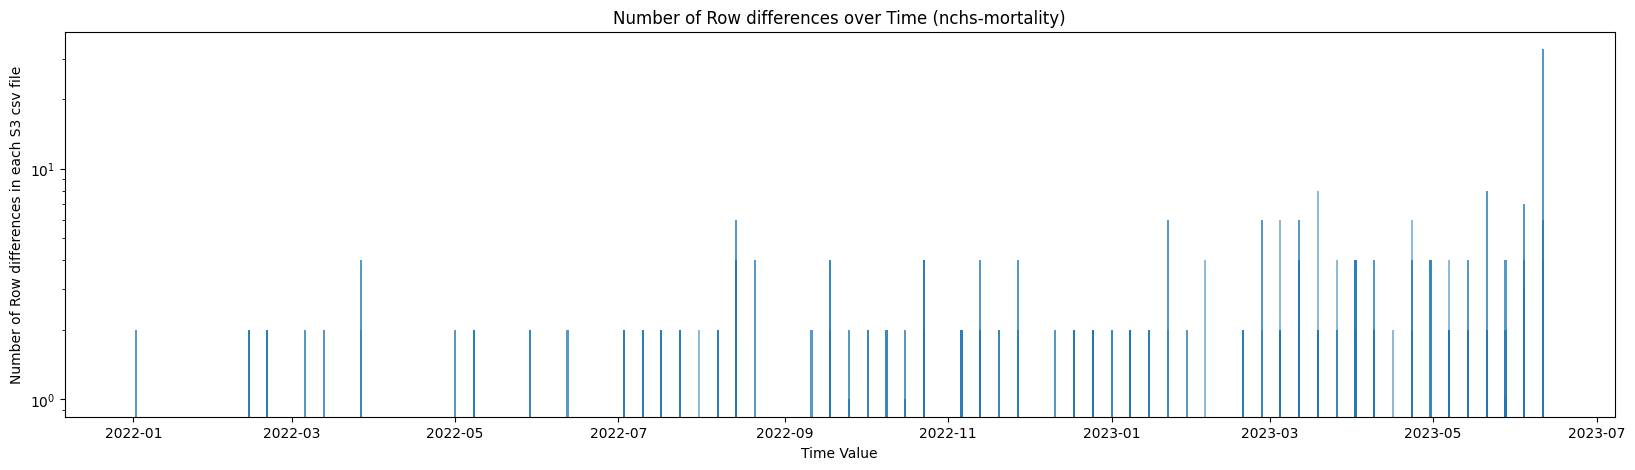

In [196]:
nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'
# Convert 'time_value' to datetime
nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')
generate_diff_over_time_plot("nchs-mortality", nchs_diff)

#### 3. chng

Around 30% of files have some differences from api.
Two major periods of mismatch:
- Mid 2020 to late 2021
- mid 2023 when the big contract patch happened.

In [197]:
chng = df[df["source"]=="chng"]

In [198]:
print(f"Files with mismatched rows: {len(chng[chng['dif_row_count']!=0])}")
print(f"Files processed: {len(chng)}")
print(f"Rate of problematic files: {len(chng[chng['dif_row_count']!=0])/len(chng)}")

Files with mismatched rows: 16174
Files processed: 51084
Rate of problematic files: 0.3166157701041422


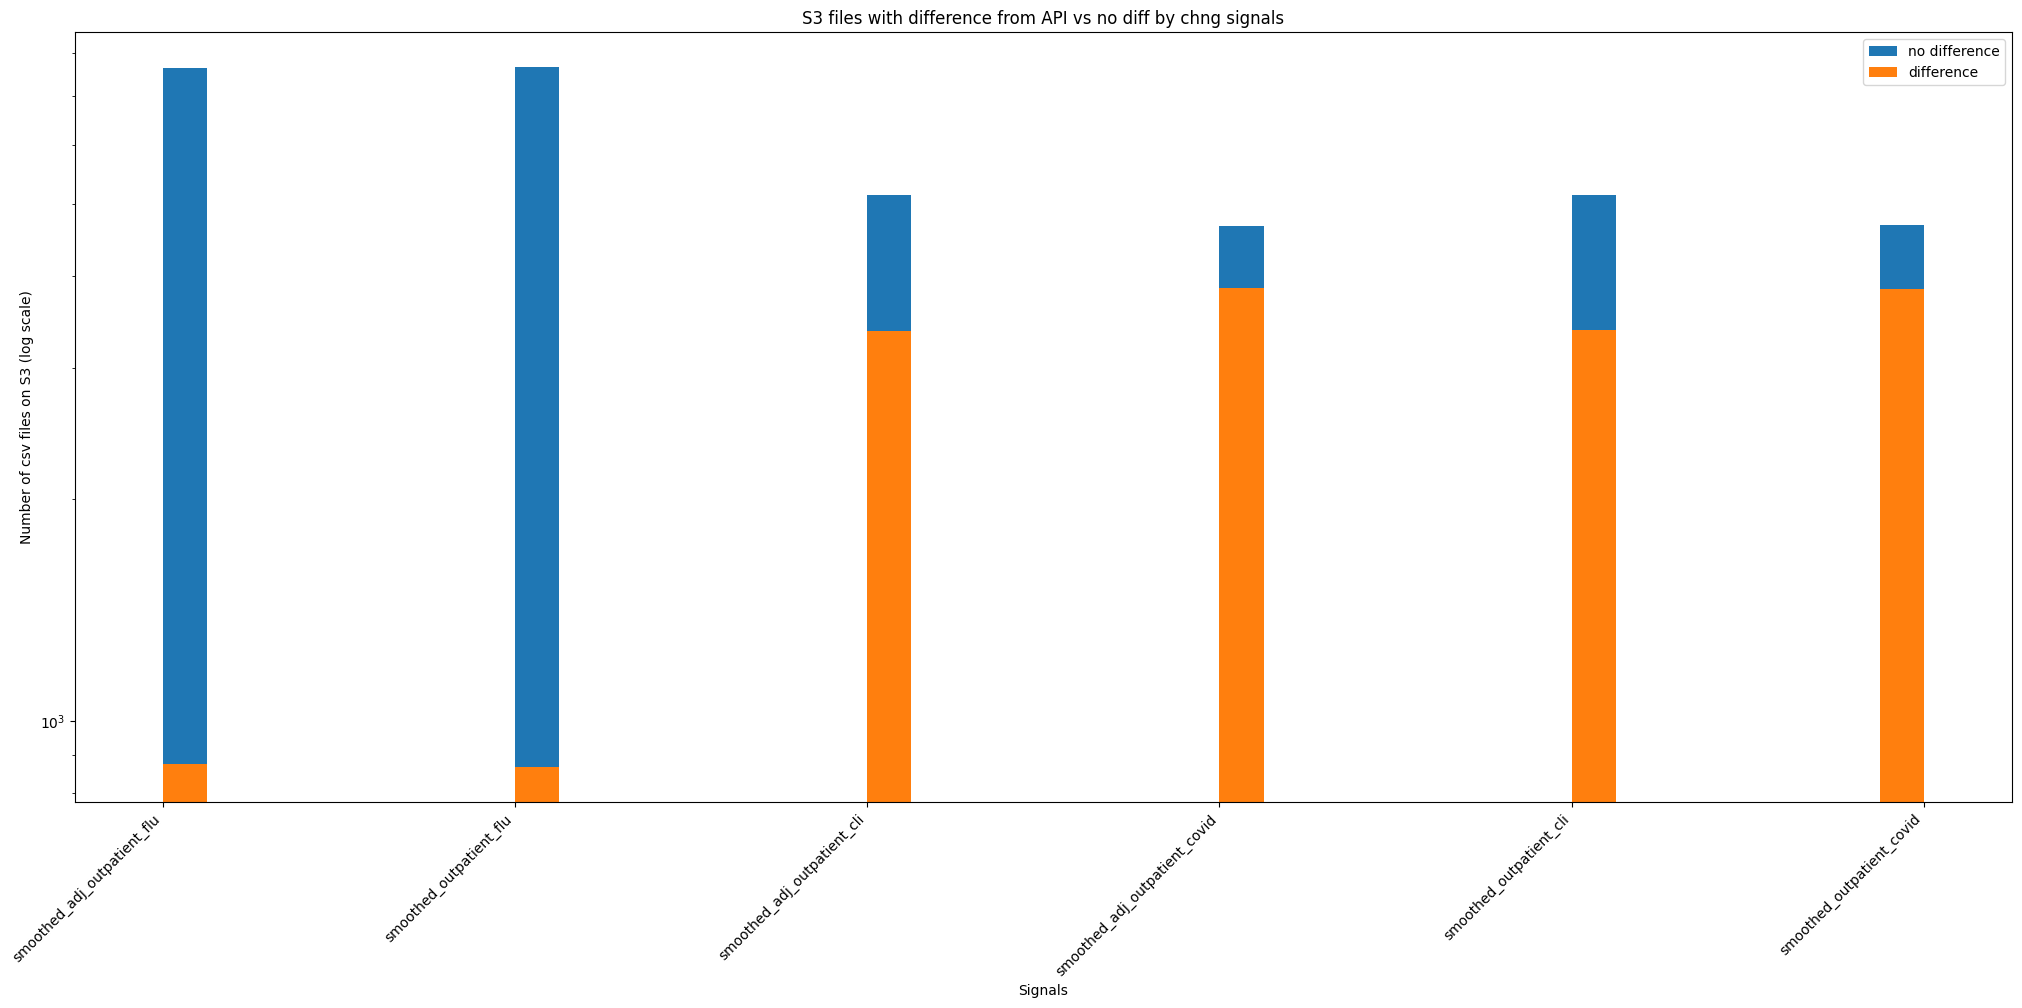

In [199]:
chng_diff = chng[chng['dif_row_count']!=0]
chng_match = chng[chng['dif_row_count']==0]

generate_diff_plot("chng", chng_match, chng_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/840467136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')


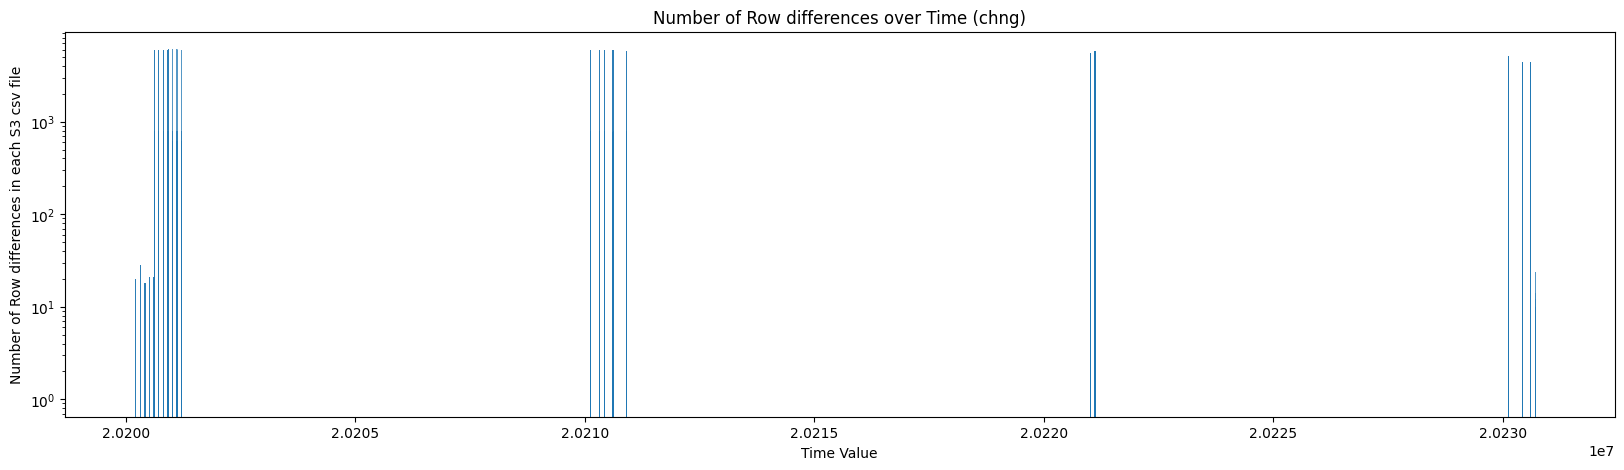

In [200]:
chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("chng", chng_diff)

#### 4.hhs
Vast majority of files for this indicator match api.
Late 2023 is when we see a spike of mismatch, right before the indicator got retired.


In [201]:
hhs= df[df["source"]=="hhs"]
# hhs.head(10)

In [202]:
print(f"Files with mismatched rows: {len(hhs[hhs['dif_row_count']!=0])}")
print(f"Files processed: {len(hhs)}")
print(f"Rate of problematic files: {len(hhs[hhs['dif_row_count']!=0])/len(hhs)}")

Files with mismatched rows: 796
Files processed: 56736
Rate of problematic files: 0.014029892836999435


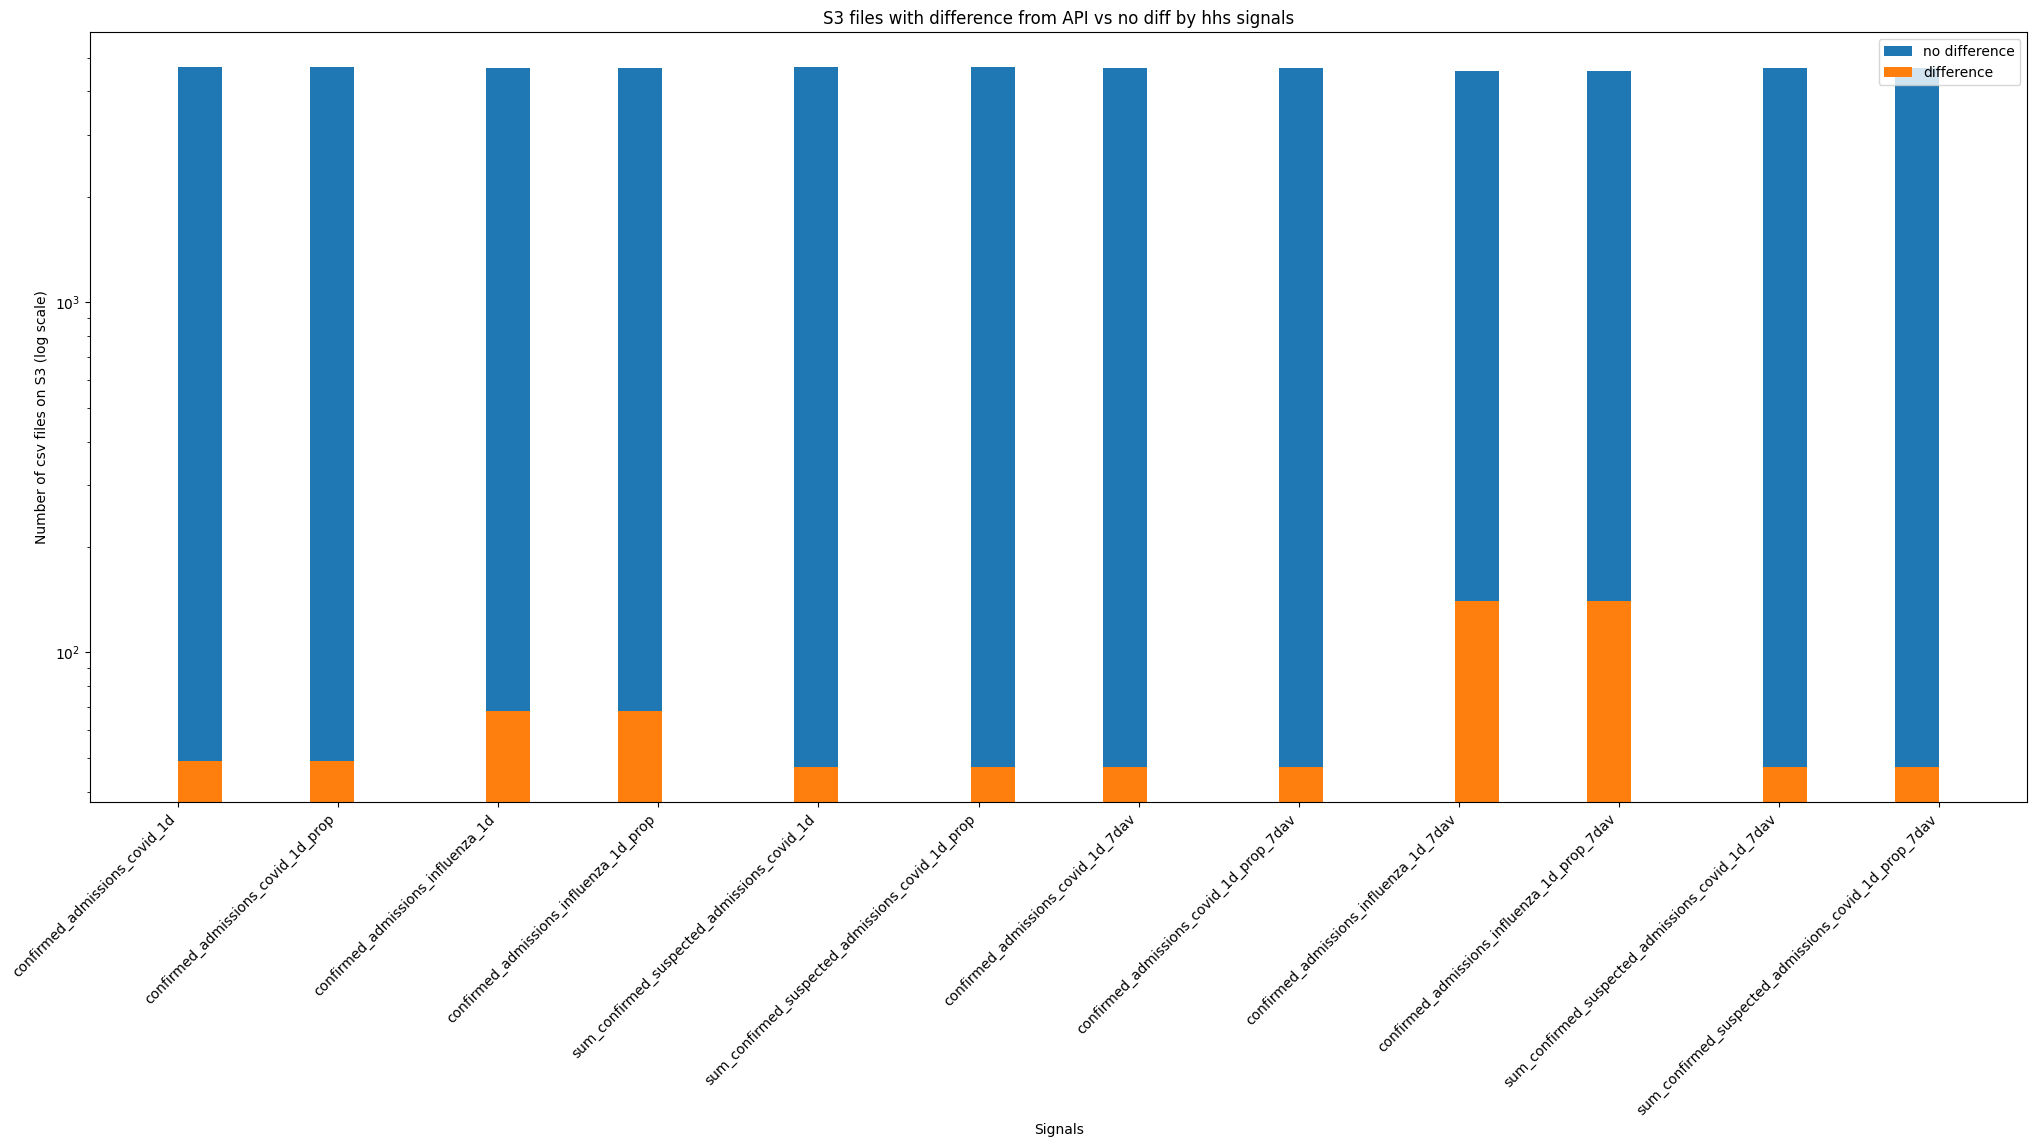

In [203]:
hhs_diff = hhs[hhs['dif_row_count']!=0]
hhs_match = hhs[hhs['dif_row_count']==0]
generate_diff_plot("hhs", hhs_match, hhs_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/3056530839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')


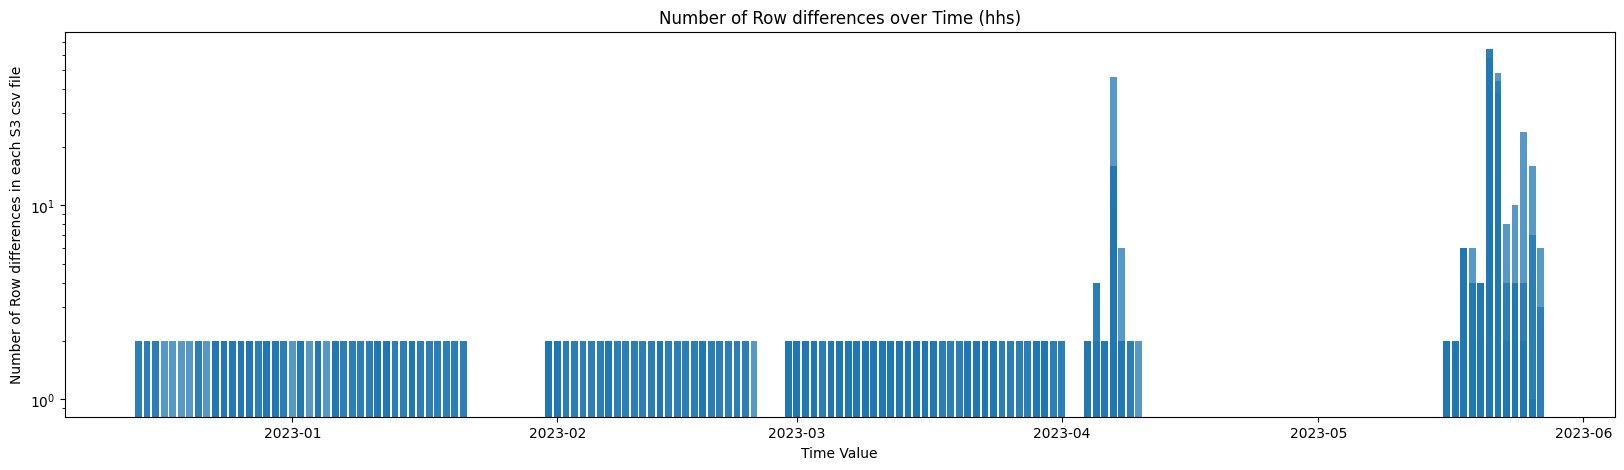

In [204]:
# Convert 'time_value' to datetime
hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("hhs", hhs_diff)

#### 5. dsew
Vast majority of the files all match. 

In [205]:
dsew = df[df["source"]=="dsew-cpr"]

In [206]:
print(f"Files with mismatched rows: {len(dsew[dsew['dif_row_count']!=0])}")
print(f"Files processed: {len(dsew)}")
print(f"Rate of problematic files: {len(dsew[dsew['dif_row_count']!=0])/len(dsew)}")

Files with mismatched rows: 53
Files processed: 15651
Rate of problematic files: 0.003386365088492748


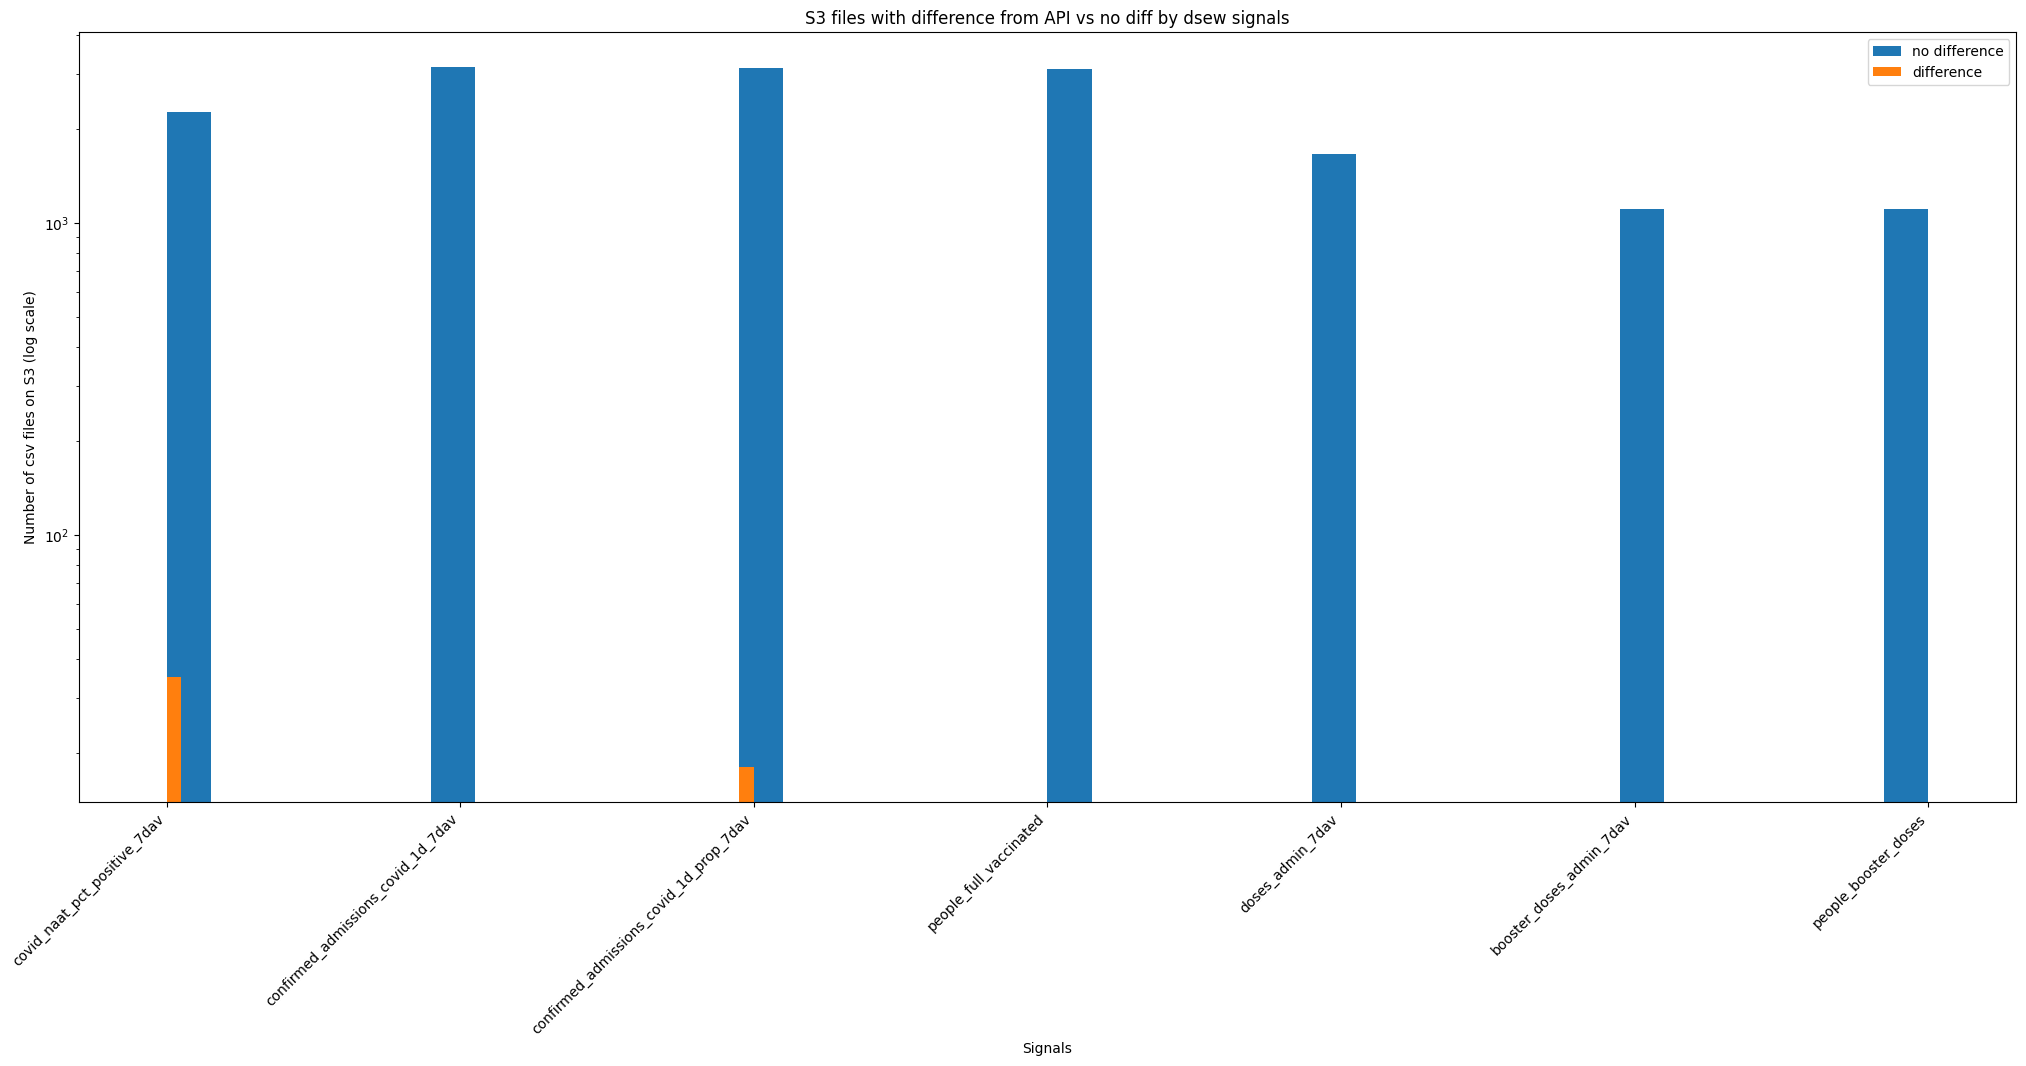

In [207]:
dsew_diff = dsew[dsew['dif_row_count']!=0]
dsew_match = dsew[dsew['dif_row_count']==0]

generate_diff_plot("dsew", dsew_match, dsew_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/3557906259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')


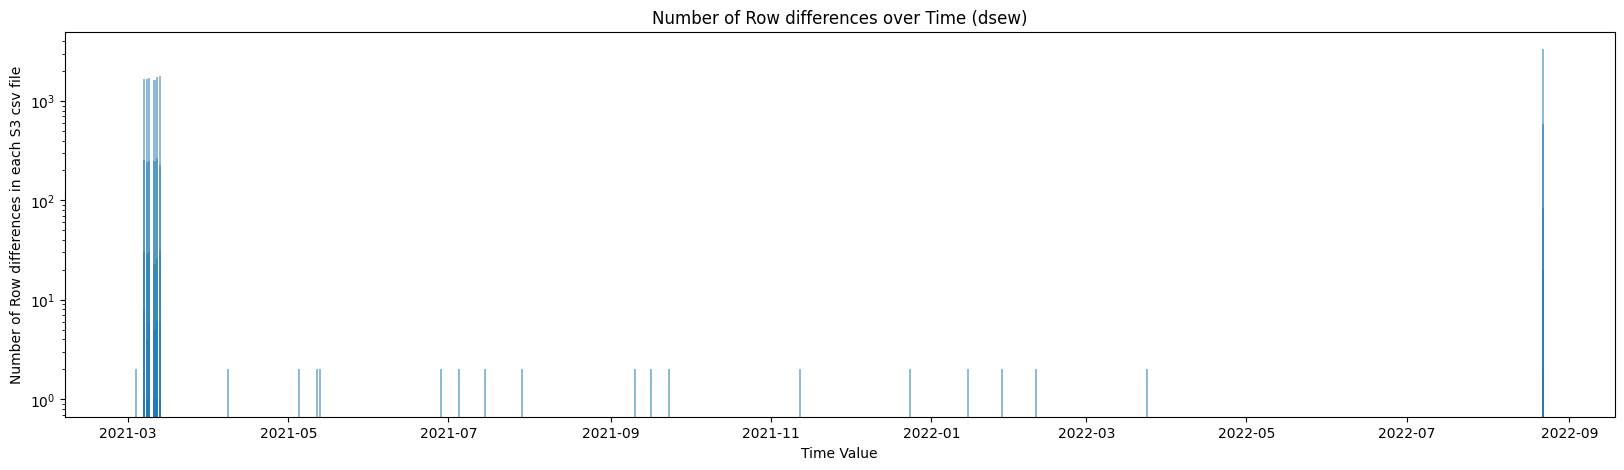

In [208]:
# Convert 'time_value' to datetime
dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("dsew", dsew_diff)

#### 6. usafacts
Vast majority of files match.
Big spike for super brief periods of time in 2020.

In [209]:
usafacts = df[df["source"]=="usa-facts"]

In [210]:
print(f"Files with mismatched rows: {len(usafacts[usafacts['dif_row_count']!=0])}")
print(f"Files processed: {len(usafacts)}")
print(f"Rate of problematic files: {len(usafacts[usafacts['dif_row_count']!=0])/len(usafacts)}")

Files with mismatched rows: 1836
Files processed: 90392
Rate of problematic files: 0.02031153199398177


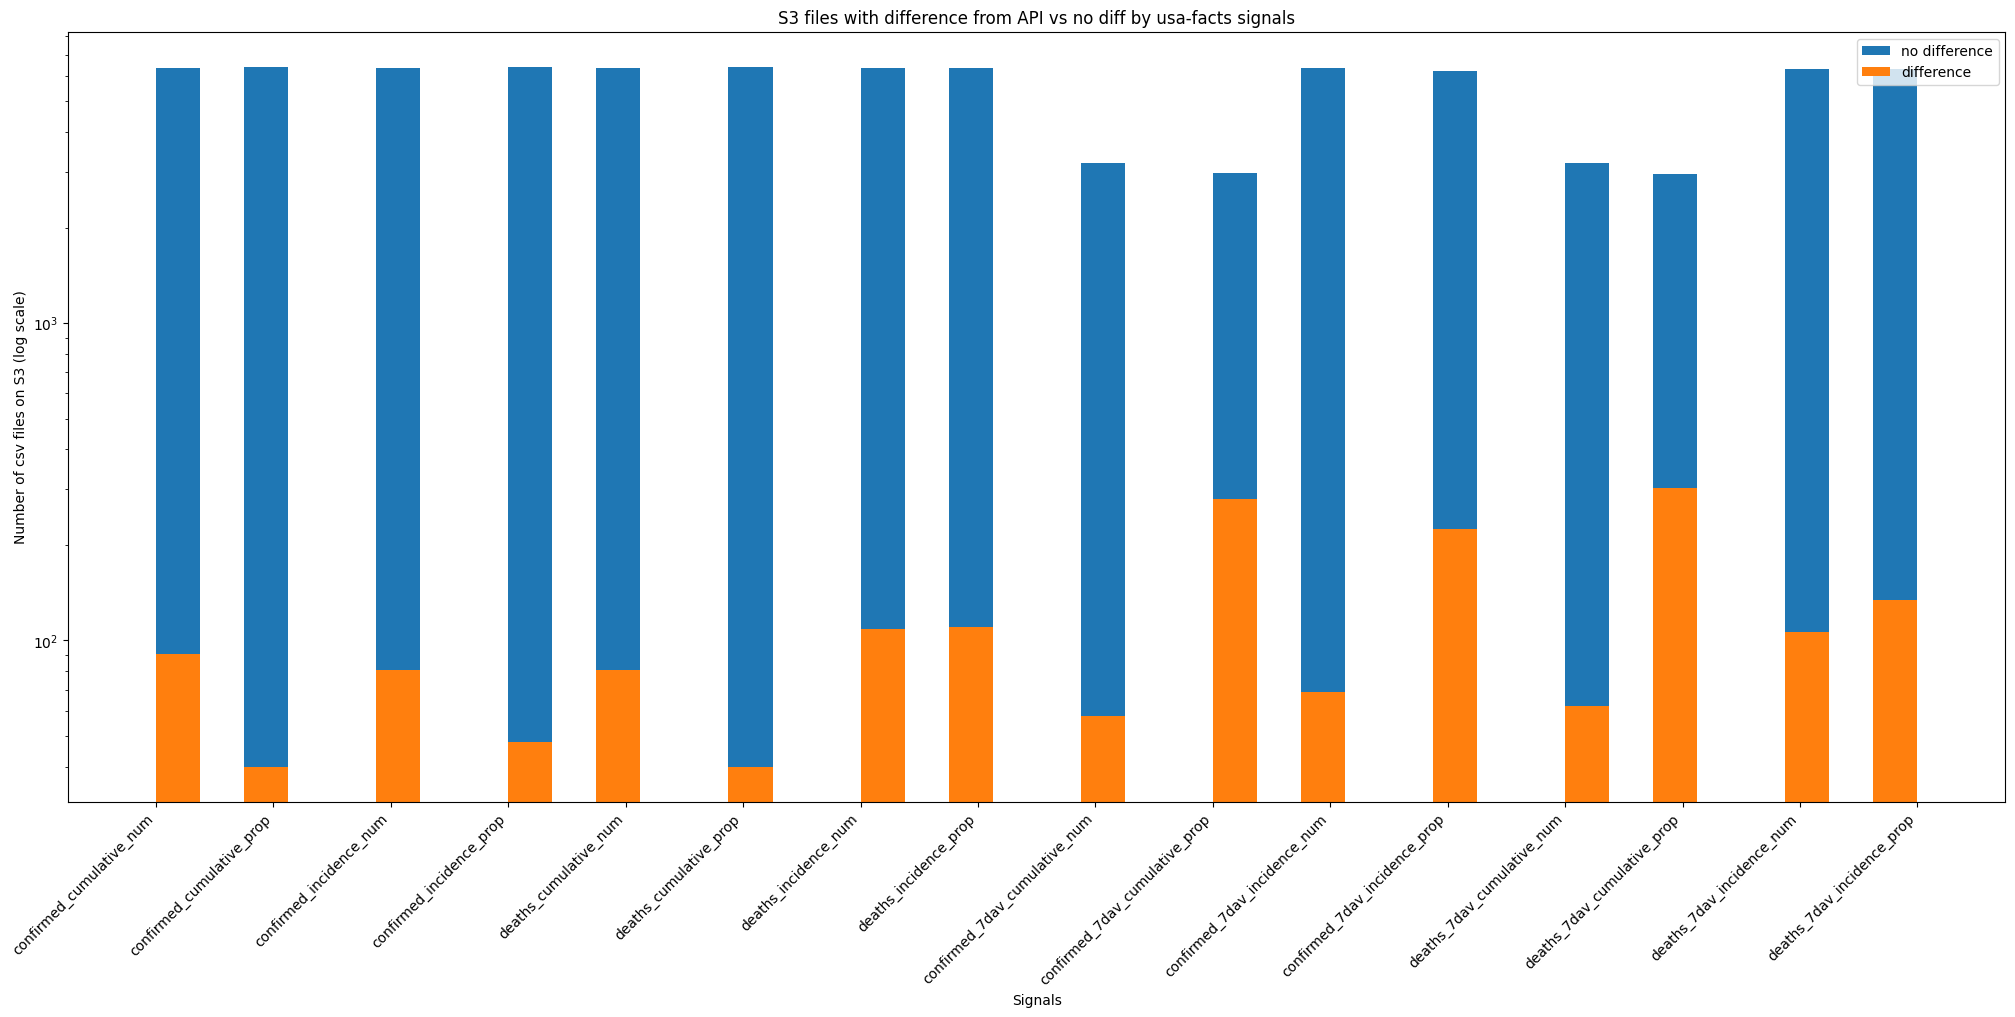

In [211]:
usafacts_diff = usafacts[usafacts['dif_row_count']!=0]
usafacts_match = usafacts[usafacts['dif_row_count']==0]

generate_diff_plot("usa-facts", usafacts_match, usafacts_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/3593630016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')


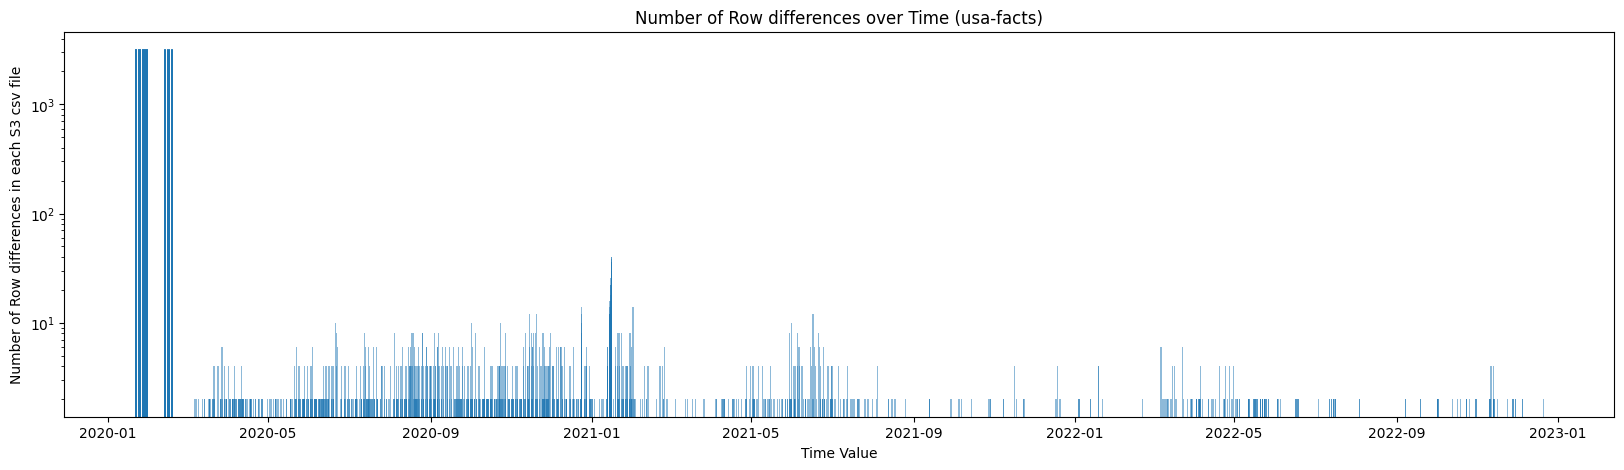

In [212]:
# Convert 'time_value' to datetime
usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("usa-facts", usafacts_diff)

#### 7. JHU
Around 20% of fies have mismatch. 
Big outlier spike in early 2023.

In [213]:
jhu = df[df["source"]=="jhu-csse"]
jhu.head()

,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,full_dif,skip,reason
0,jhu/20200220_county_confirmed_7dav_cumulative_...,jhu-csse,confirmed_7dav_cumulative_prop,20200220,county,4.0,3270.0,3274.0,0.0,False,NaN
1,jhu/20200220_county_confirmed_7dav_incidence_n...,jhu-csse,confirmed_7dav_incidence_num,20200220,county,4.0,3278.0,3282.0,0.0,False,NaN
2,jhu/20200220_county_confirmed_7dav_incidence_p...,jhu-csse,confirmed_7dav_incidence_prop,20200220,county,56.0,3219.0,3275.0,0.0,False,NaN
3,jhu/20200220_county_confirmed_cumulative_num.csv,jhu-csse,confirmed_cumulative_num,20200220,county,4.0,3278.0,3282.0,0.0,False,NaN
4,jhu/20200220_county_confirmed_cumulative_prop.csv,jhu-csse,confirmed_cumulative_prop,20200220,county,56.0,3219.0,3275.0,0.0,False,NaN


In [214]:
print(len(jhu[jhu['dif_row_count']!=0]))
print(len(jhu))
print(len(jhu[jhu['dif_row_count']!=0])/len(jhu))

15832
92608
0.17095715272978576


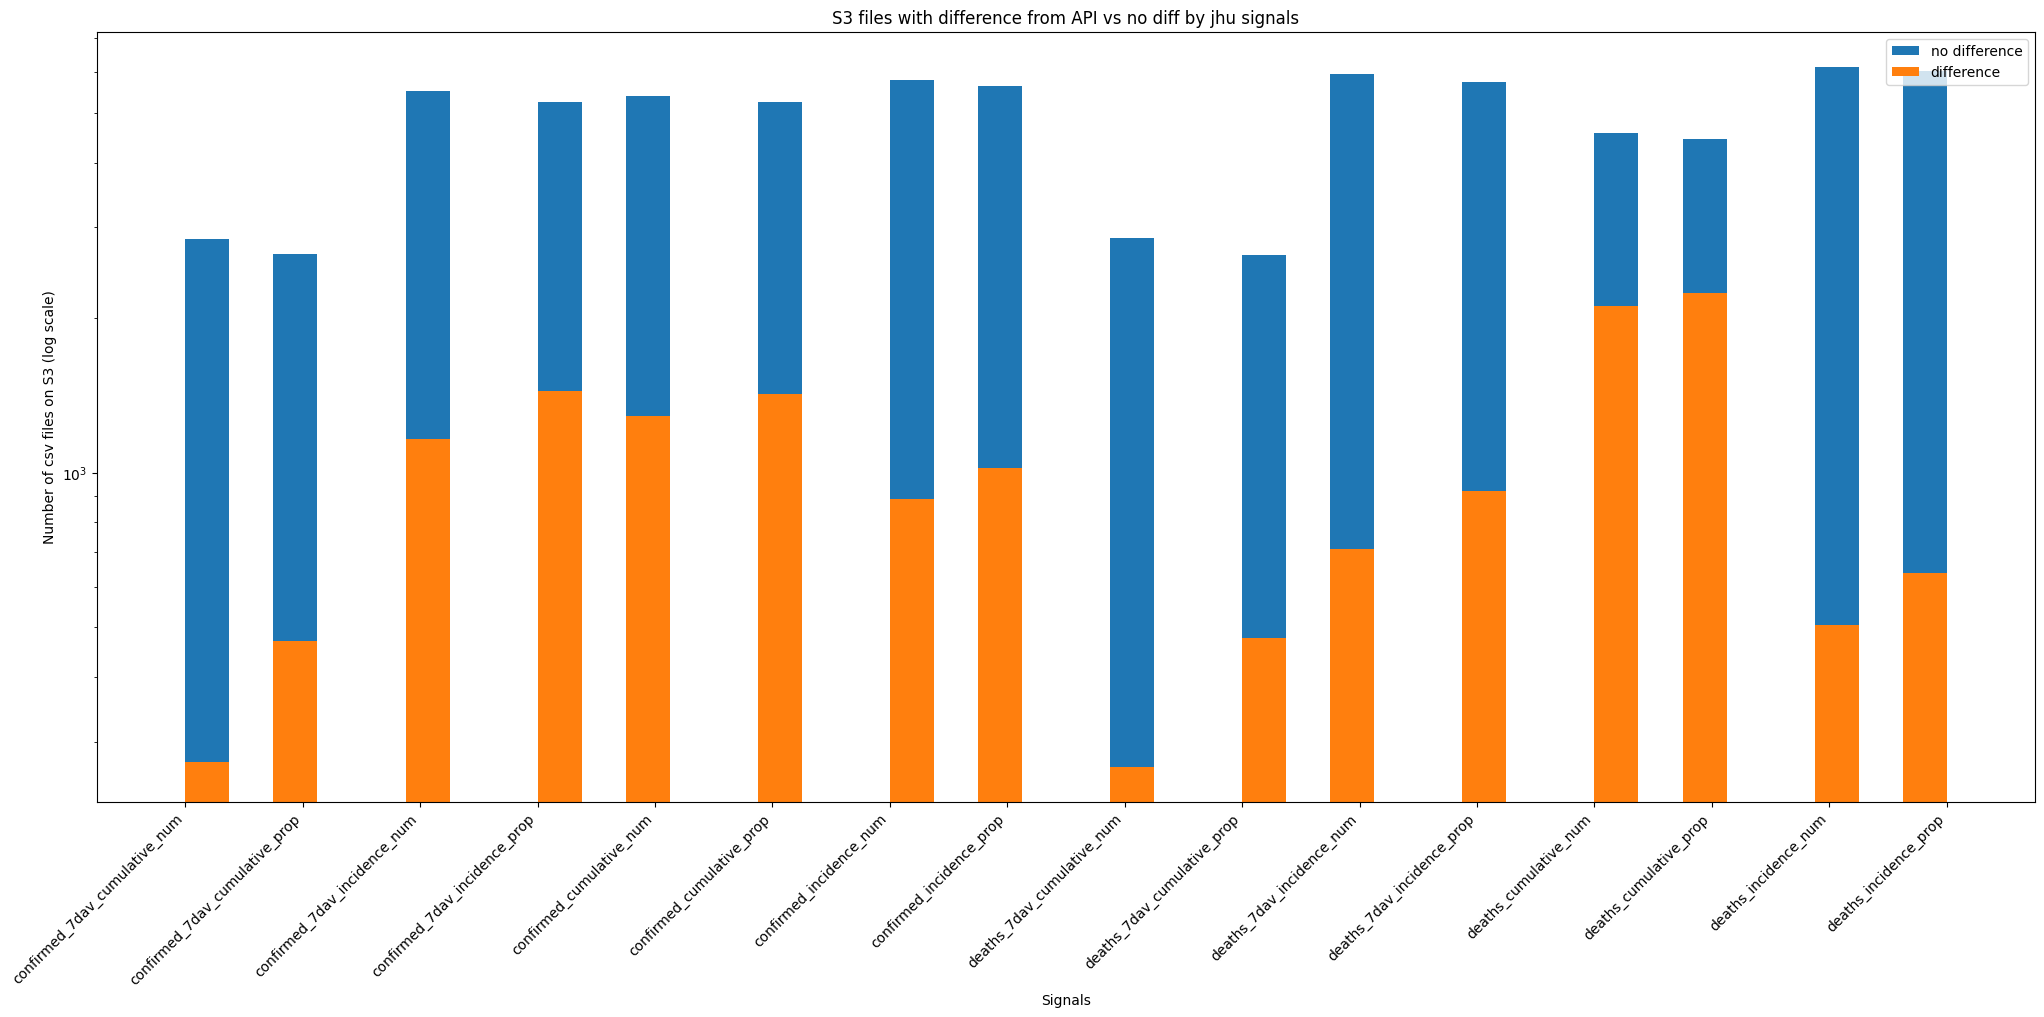

In [215]:
jhu_diff = jhu[jhu['dif_row_count']!=0]
jhu_match = jhu[jhu['dif_row_count']==0]

generate_diff_plot("jhu", jhu_match, jhu_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_32080/3872599711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jhu_diff['time_value'] = pd.to_datetime(jhu_diff['time_value'], format='%Y%m%d')


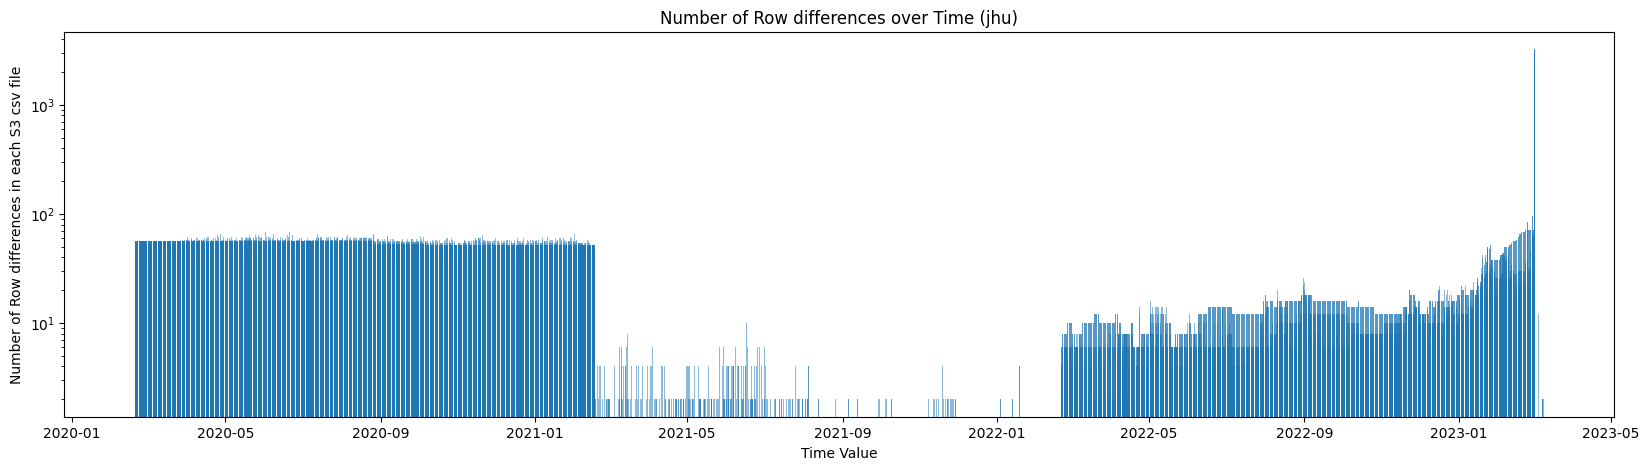

In [216]:
# Convert 'time_value' to datetime
jhu_diff['time_value'] = pd.to_datetime(jhu_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("jhu", jhu_diff)